import libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt


from support.functions import kmeans
from support.plots import show_k,plot_cluster_means
from support.hyperphoto import HyperPhoto
from support.split_lub import SplitBub

parameters

In [2]:
# פרמטרים מה-header
width = 800  # עמודות (x)
height = 280  # שורות (y)
bands = 126  # ערוצים (z)
source_path = r'C:\Users\ronsh\Desktop\big_data_for_projects\self_test_rad.img'
dtype = np.int16  # data type = 2
# פרמטרים לניתוח גרפים
range_ = (0, 1000)
bins = 500



import hyper photo

In [3]:
shape = (height,width, bands)

hyperPhoto = HyperPhoto(source_path, shape, np.int16)


In [4]:
data = hyperPhoto.data
domain = []
for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        domain.append([x, y])
domain = torch.tensor(domain, dtype=torch.int16).reshape(list(data.shape[:2]) + [2])

k_means

initial statistics

In [5]:
hyperPhoto.initial_statistics()
_=hyperPhoto.compute_rx()


init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


split functions

In [6]:
def k_mean_centr(domain, hyperphoto, k,max_iters=100000000):
    shape = hyperphoto.data.shape
    samples = []
    segmented_photo = []
    centroids, labels = kmeans(hyperPhoto.data.reshape(-1, hyperphoto.error8.size(-1)), k, max_iters)
    for  id in range(k):
        segmented_photo.append((labels == id).reshape(shape[:2]).int())
        samples.append(domain.view(-1, 2)[labels == id])
    return centroids, labels , samples ,segmented_photo


In [7]:
target_path = "../data/t.pt"
p = 0.03
k = 5
centroids, labels , samples ,segmented_photo = k_mean_centr(domain, hyperPhoto, k)

In [8]:
sizes_ = torch.tensor([s.sum().item() for s in samples])
sizes_

tensor([24550199,  8822617,  8868475, 61435851, 17058858])

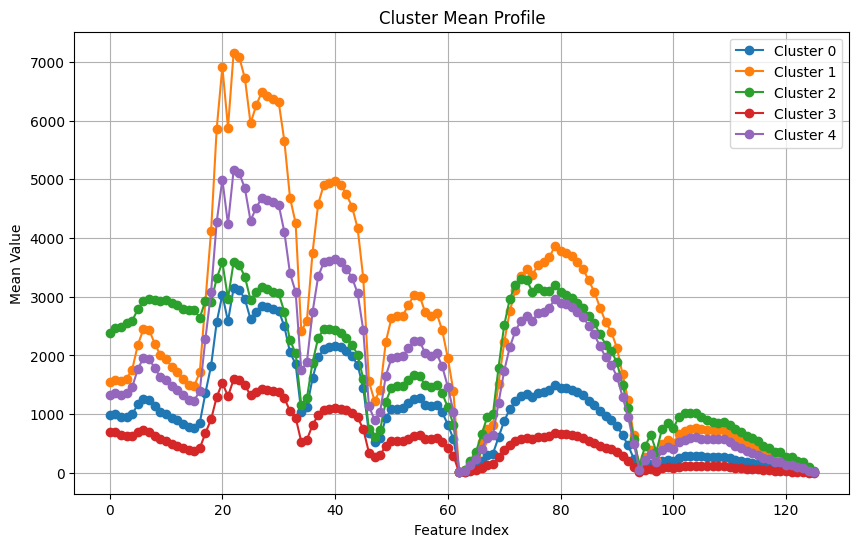

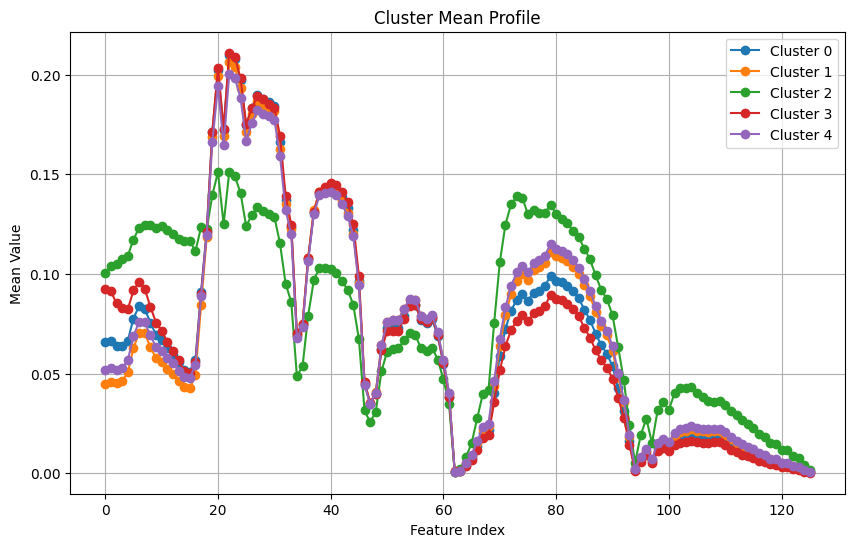

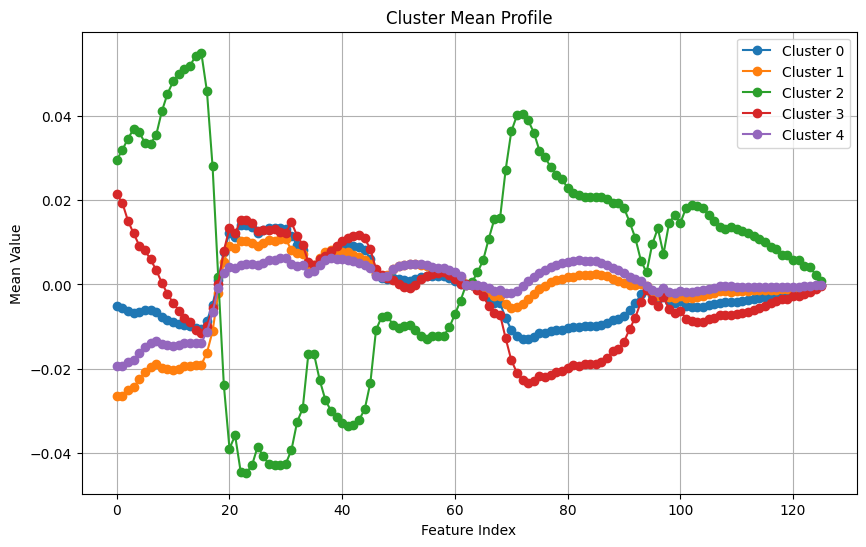

In [9]:
plot_cluster_means(centroids, range(labels.max()+1))
centroids_n = centroids/ centroids.norm(dim=1, keepdim=True)
plot_cluster_means(centroids_n, range(labels.max()+1))



weights = sizes_ / sizes_.sum()

mean = (centroids_n * weights.unsqueeze(1)).sum(dim=0)
var  = (weights.unsqueeze(1) * (centroids_n - mean) ** 2).sum(dim=0)
std_ = torch.sqrt(var)


centroids_n = centroids_n - centroids_n.mean(dim=0, keepdim=True)
plot_cluster_means(centroids_n, range(labels.max()+1))
centroids_n = (centroids_n*centroids_n).sum(dim=1)

In [10]:
std_

tensor([0.0188, 0.0183, 0.0169, 0.0162, 0.0148, 0.0135, 0.0127, 0.0126, 0.0138,
        0.0147, 0.0155, 0.0160, 0.0163, 0.0166, 0.0174, 0.0177, 0.0147, 0.0090,
        0.0009, 0.0082, 0.0135, 0.0124, 0.0155, 0.0155, 0.0148, 0.0132, 0.0139,
        0.0144, 0.0145, 0.0144, 0.0142, 0.0138, 0.0113, 0.0100, 0.0055, 0.0055,
        0.0074, 0.0089, 0.0098, 0.0104, 0.0111, 0.0114, 0.0114, 0.0112, 0.0103,
        0.0080, 0.0037, 0.0025, 0.0024, 0.0031, 0.0035, 0.0035, 0.0035, 0.0037,
        0.0040, 0.0042, 0.0040, 0.0039, 0.0040, 0.0033, 0.0023, 0.0014, 0.0001,
        0.0002, 0.0011, 0.0022, 0.0041, 0.0057, 0.0059, 0.0103, 0.0141, 0.0160,
        0.0168, 0.0169, 0.0163, 0.0150, 0.0149, 0.0144, 0.0139, 0.0137, 0.0131,
        0.0126, 0.0127, 0.0124, 0.0124, 0.0125, 0.0121, 0.0116, 0.0106, 0.0103,
        0.0092, 0.0073, 0.0054, 0.0028, 0.0011, 0.0034, 0.0047, 0.0026, 0.0052,
        0.0059, 0.0053, 0.0067, 0.0071, 0.0071, 0.0070, 0.0064, 0.0060, 0.0056,
        0.0054, 0.0054, 0.0053, 0.0051, 

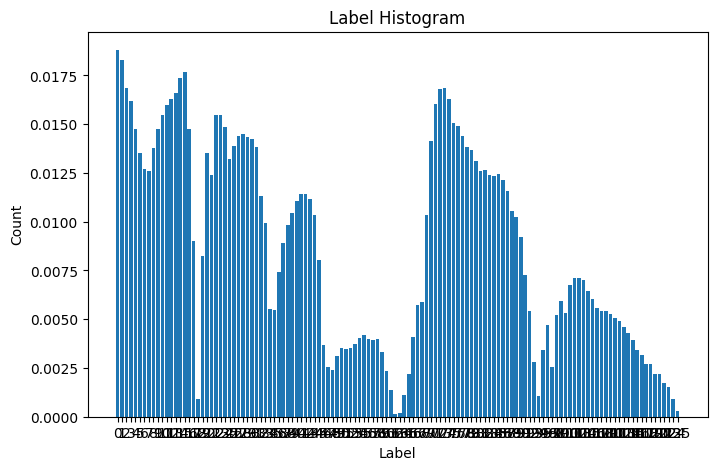

In [11]:

plt.figure(figsize=(8, 5))
plt.bar(range(std_.size(0)), std_.numpy())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Histogram")
plt.xticks(range(std_.size(0)))
plt.show()


init error
torch.Size([280, 800, 126])
init cov
torch.Size([126, 126])


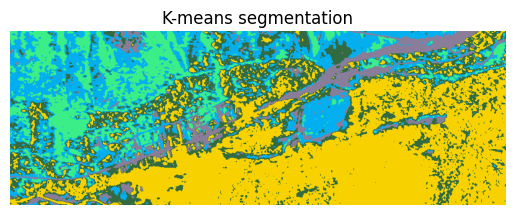

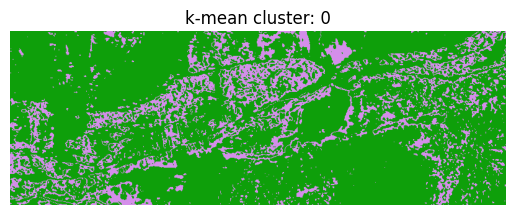

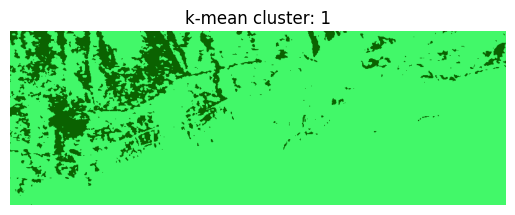

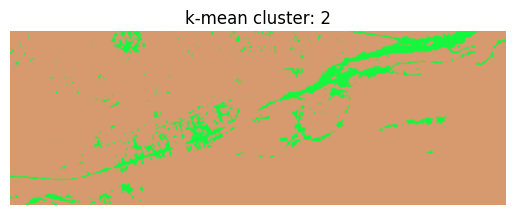

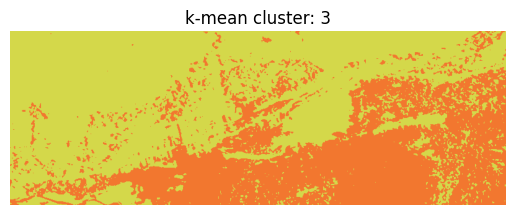

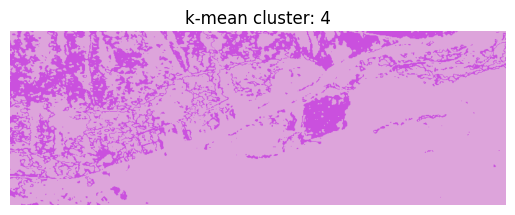

In [12]:
forplot = []
splitBub = SplitBub(source_path,shape,target_path,p)
show_k(labels,hyperPhoto.data.shape[:2])
for id in range(k):
    show_k(segmented_photo[id],hyperPhoto.data.shape[:2],f"k-mean cluster: {id}")
    splitBub.compute_p(samples[id])
    forplot.append((f"k-min id:{id}",splitBub.show_analize(range_ = (-500,500),show=False)))

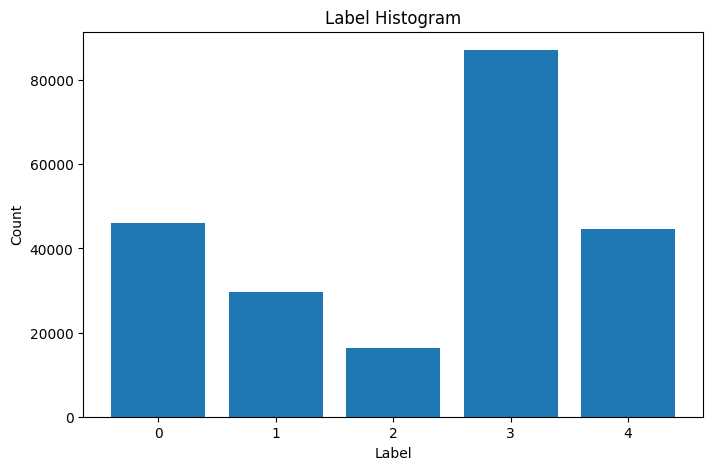

In [13]:

counts = np.bincount(labels.numpy(), minlength=k)

plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Histogram")
plt.xticks(range(len(counts)))
plt.show()

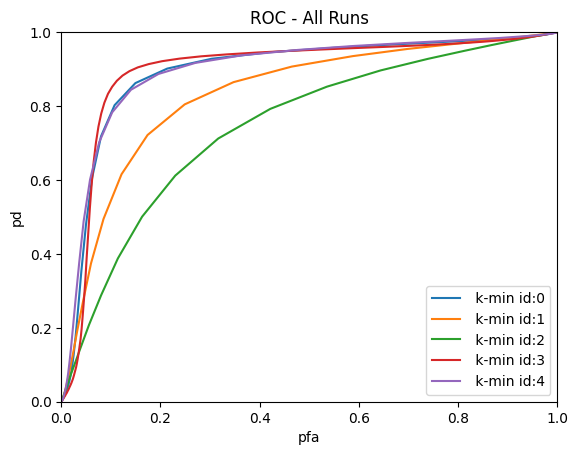

In [14]:
plt.figure()

for name,(l,r) in forplot:
    plt.plot(l, r, label=f" {name}")

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC - All Runs")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


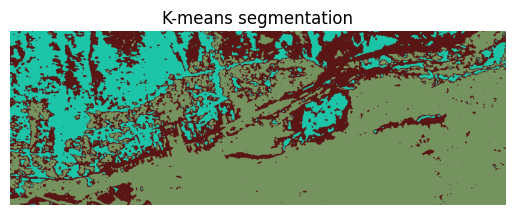

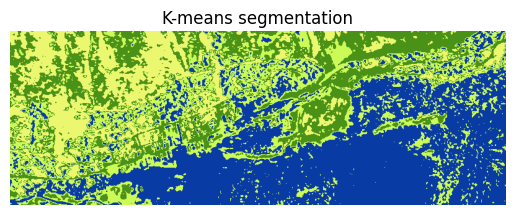

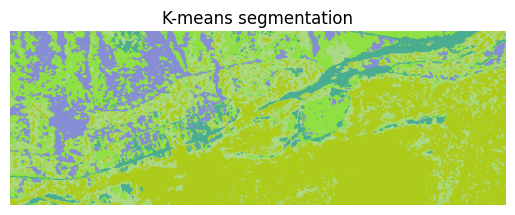

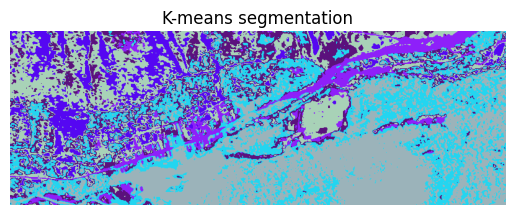

In [15]:
target_path = "../data/t.pt"
p = 0.03
for k in range(3,7,1):
    centroids, labels , samples ,segmented_photo = k_mean_centr(domain, hyperPhoto, k)
    counts = torch.bincount(labels, minlength=k)
    #splitBub = SplitBub(source_path,shape,target_path,p)
    show_k(labels,hyperPhoto.data.shape[:2])
    id = torch.argmax(counts)
    splitBub.compute_p(samples[id])
    forplot.append((f"k-mean{k} id:{id}",splitBub.show_analize(range_ = (-500,500),show=False)))

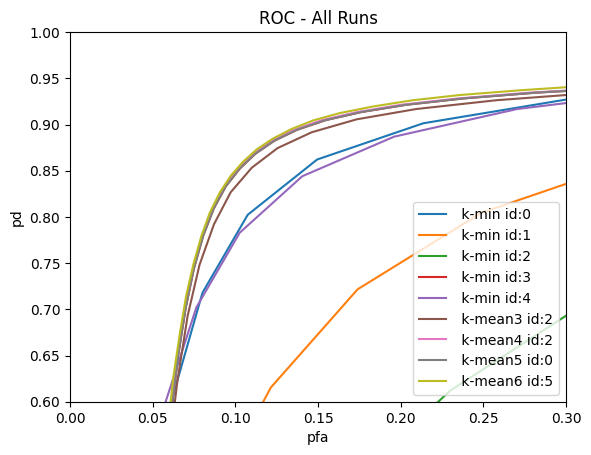

In [16]:
plt.figure()

for name,(l,r) in forplot:
    plt.plot(l, r, label=f" {name}")

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC - All Runs")
plt.legend()
plt.xlim(0, 0.3)
plt.ylim(0.6, 1)
plt.show()

In [17]:
forplot = [forplot[5]]
def k_smolest(domain, hyperphoto, k):
    _, idx = torch.sort(hyperphoto.rx.view(-1))
    return domain.view(-1, 2)[idx[:k]]
for n in range(50000,50001,22400):
    id = k_smolest(domain,hyperPhoto, n)
    splitBub.compute_p(id)
    forplot.append((f"k-min{n}",splitBub.show_analize(bins_=1000,range_ = (-2000,2000),show=False)))


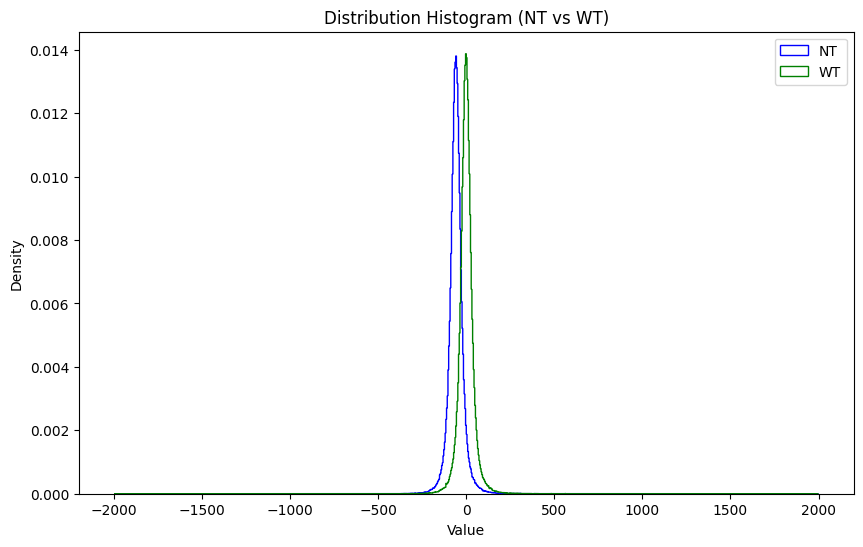

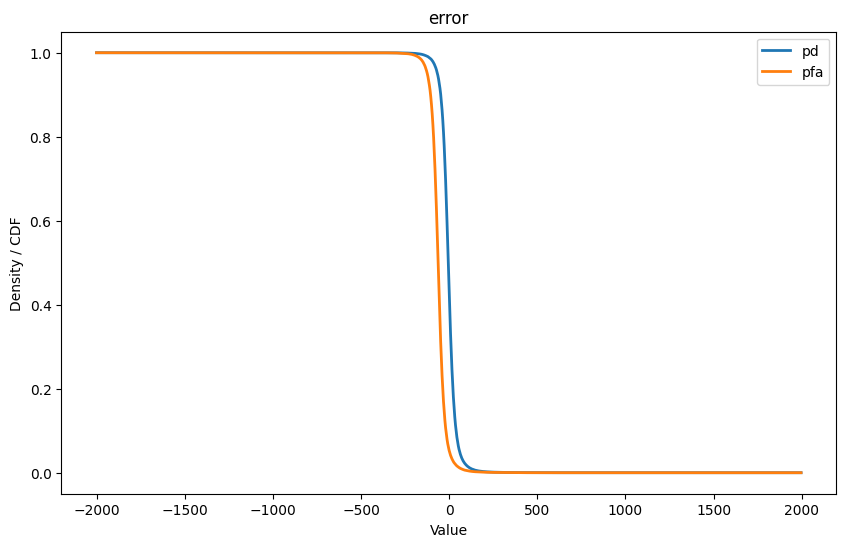

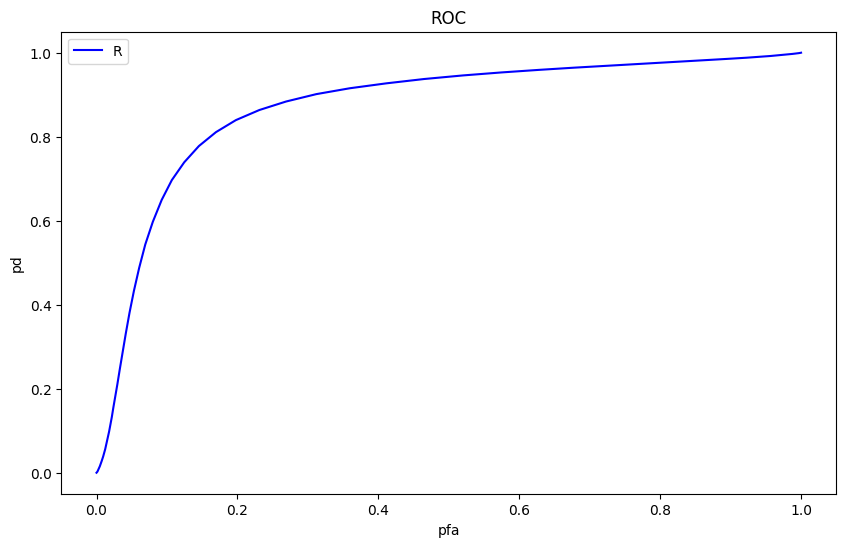

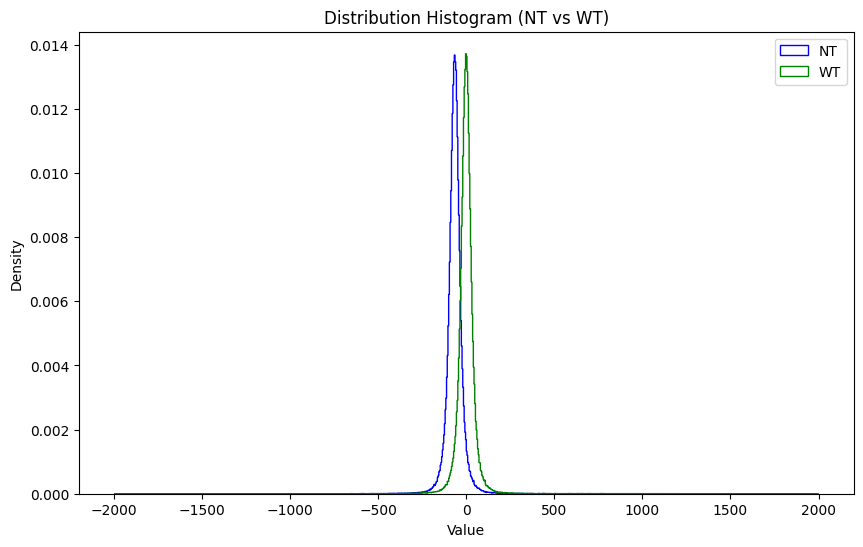

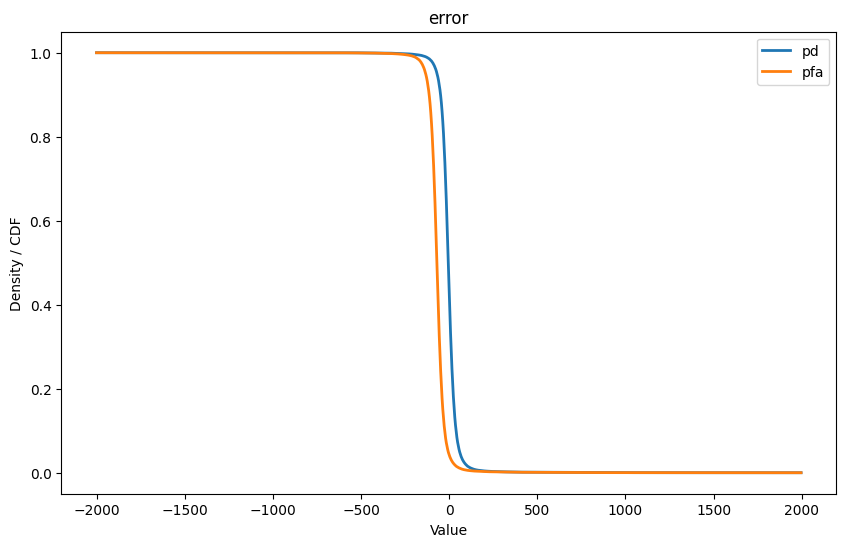

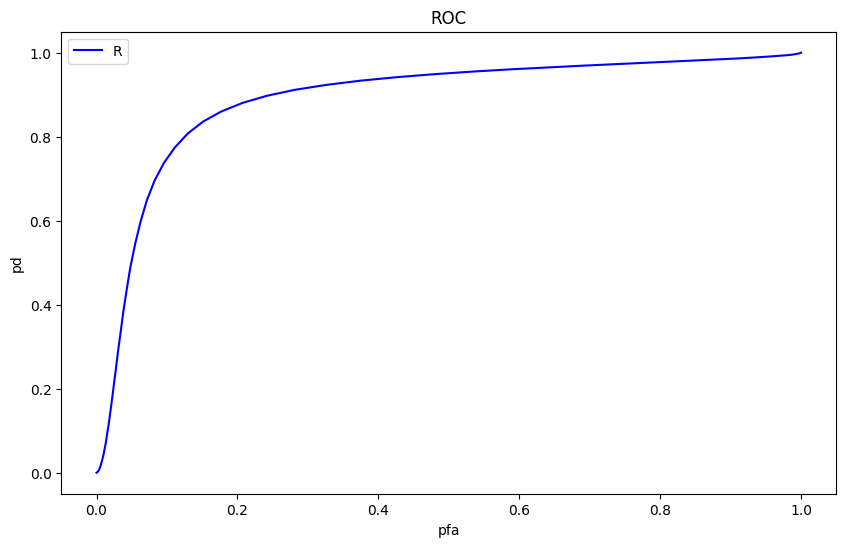

In [18]:

def k_top(domain, hyperphoto, k):
    return domain.view(-1, 2)[range(k)]
def random_split(domain, hyperphoto,smple_size):
    place = torch.randint(0, domain.size(0) * domain.size(1), (smple_size,))
    return domain.view(-1, 2)[place]



splitBub.compute_p(random_split(domain, hyperPhoto,112000))
forplot.append((f"random half ",splitBub.show_analize(bins_=1000,range_ = (-2000,2000))))

splitBub.compute_p(k_top(domain, hyperPhoto,112000))
forplot.append((f"k_top half ",splitBub.show_analize(bins_=1000,range_ = (-2000,2000))))

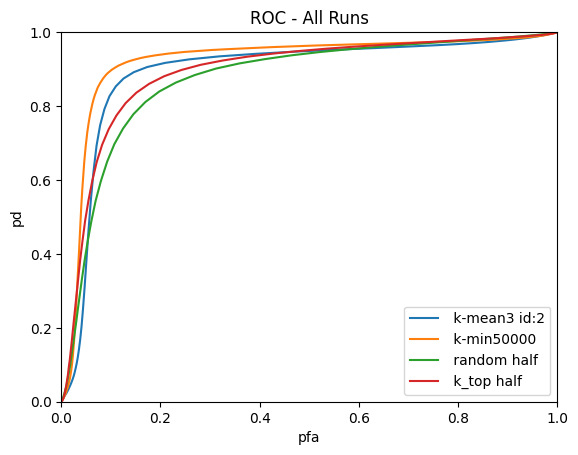

In [19]:
plt.figure()

for name,(l,r) in forplot:
    plt.plot(l, r, label=f" {name}")

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC - All Runs")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

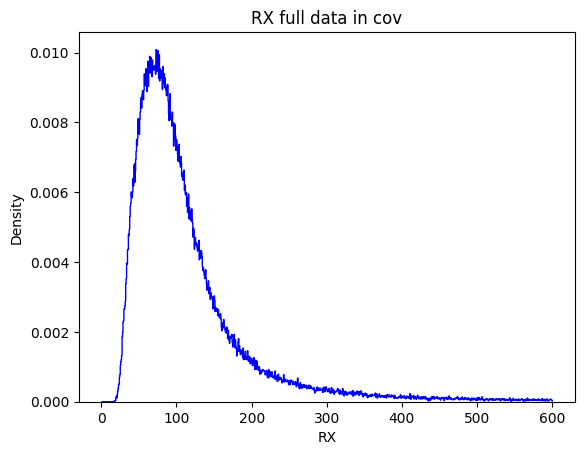

In [31]:

plt.hist(hyperPhoto.rx.reshape(-1).numpy(), bins=1000, range=(0,600),
                     density=True, histtype='step', color='blue')

plt.xlabel("RX")
plt.ylabel("Density")
plt.title("RX full data in cov")
plt.show()
